# Apriori Algorithm: Implementation and Evaluation

**In this study, we try to implement the Apriori algorithm on an e-commerce electronics store dataset which consists of user-session data. The objective is to find uncommon / out-of-the-box association rules between specific electronic products with the intent to boost sales of these products by explicitly promoting them together.**

**Link to our Medium article on this study:**

In [1]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specific code we want to hide:
# ==============================
# @hidden
from IPython.display import HTML
password="xxxxx"
# ==============================

# Necessary script to hide the cell:
# ==============================
HTML('''<script>
  code_show=true; 
  function code_toggle() {
    if (code_show){
        $('.cm-comment:contains(@hidden)').closest('div.input').hide();
    } else {
        $('.cm-comment:contains(@hidden)').closest('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
To show the code hidden: click <a href="javascript:code_toggle()">here</a>.''')
# ==============================

In [3]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
#link for this dataset: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
df_main = pd.read_csv("data/2019-Oct.csv")
df_main = df_main[df_main['event_type'] == "purchase"]

**Using the above code we have filtered out only "purchase" data for further use and eliminated "view" and "add-to-cart" events**

In [5]:
#dropping the records having any missing values.
df_main = df_main.dropna(axis=0)

In [6]:
# For converting the date string to datetime
df_main['event_time']=pd.to_datetime(df_main.event_time, format='%Y-%m-%d %H:%M:%S %Z')
df_main['day'] = df_main['event_time'].dt.day

In [7]:
# Method for extracting the product type which is located at the end of the values in the category_code field.
def string_split(string1):
    main_string = string1.split('.')[-1]
    main_string = main_string.strip()
    return main_string

In [8]:
df_main['productType']=df_main['category_code'].transform(string_split)

In [9]:
df_main.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,day,productType
162,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,smartphone
308,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,smartphone
442,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,toilet
574,2019-10-01 00:09:26+00:00,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,1,headphone
603,2019-10-01 00:09:54+00:00,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,headphone


In [10]:
# In the same "user_session", four smartphones having a same product_id are purchased. The timestamps are different. 
df_main[df_main['user_session']=='01216c46-646d-4e1f-b896-015c6101f8bf']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,day,productType
678072,2019-10-01 13:09:35+00:00,purchase,1004750,2053013555631882655,electronics.smartphone,samsung,203.35,555599569,01216c46-646d-4e1f-b896-015c6101f8bf,1,smartphone
682142,2019-10-01 13:13:30+00:00,purchase,1004750,2053013555631882655,electronics.smartphone,samsung,203.35,555599569,01216c46-646d-4e1f-b896-015c6101f8bf,1,smartphone
682996,2019-10-01 13:14:17+00:00,purchase,1004750,2053013555631882655,electronics.smartphone,samsung,203.35,555599569,01216c46-646d-4e1f-b896-015c6101f8bf,1,smartphone
685681,2019-10-01 13:16:46+00:00,purchase,1004750,2053013555631882655,electronics.smartphone,samsung,203.35,555599569,01216c46-646d-4e1f-b896-015c6101f8bf,1,smartphone


__The above query shows a single user_session in which same smartphone is ordered for 4 times but at different times.__

# Extras on Data:

- Assumption based on the above finding, each log/record is considered as a single item.

# Combined code Encapsulation

In [11]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x> 0):
        return 1
def RuleMiner(dataframe, min_support_popular_set=0.001,min_support_rules=0.001, metric='lift'):
    """Function to get rules based on the support threshold and metric. 
    dataframe: Dataframe which contains the transactions in the specified schema.
    min_support_set: The threshold for filtering the frequent item sets having more support value than threshold.
    min_support_rules: The threshold for filtering the rules having metric value more than threshold
    metric: lift, support, confidence"""
    df=dataframe
    msPS = min_support_popular_set
    msAR = min_support_rules
    metric=metric
    prod_counts = df.groupby(by='user_session')[['productType']].count()
    df_prod_count_combined = pd.merge(df,prod_counts, on='user_session')
    
    df_prod_count_combined.rename(columns = {'productType_x':'productType'}, inplace = True)
    df_prod_count_combined.rename(columns = {'productType_y':'quantity'}, inplace = True)
    
    basket = df_prod_count_combined.groupby(
        ['user_session','productType'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('user_session')
    
    basket_model = basket.applymap(hot_encode)
    popular_sets = apriori(basket_model, min_support=msPS, use_colnames=True, verbose = 1)
    popular_sets['length'] = popular_sets['itemsets'].apply(lambda x: len(x))
    rules = association_rules(popular_sets, metric=metric, min_threshold = msAR)
    rules = rules.sort_values(['lift'], ascending =[False])
    #rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
    return rules

## df_main (Including All brands)

In [12]:
warnings.filterwarnings('ignore')
RuleMiner(df_main)

Processing 9 combinations | Sampling itemset size 3e 2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(smartphone),(clocks),0.610415,0.031817,0.001617,0.002650,0.083279,-0.017804,0.970755
1,(clocks),(smartphone),0.031817,0.610415,0.001617,0.050835,0.083279,-0.017804,0.410450
4,(smartphone),(notebook),0.610415,0.029167,0.001236,0.002025,0.069428,-0.016568,0.972803
5,(notebook),(smartphone),0.029167,0.610415,0.001236,0.042380,0.069428,-0.016568,0.406826
2,(smartphone),(headphone),0.610415,0.058576,0.002474,0.004053,0.069201,-0.033281,0.945256
3,(headphone),(smartphone),0.058576,0.610415,0.002474,0.042241,0.069201,-0.033281,0.406768
6,(smartphone),(tv),0.610415,0.041142,0.001735,0.002843,0.069095,-0.023378,0.961592
7,(tv),(smartphone),0.041142,0.610415,0.001735,0.042177,0.069095,-0.023378,0.406740


In [13]:
#Code for knowing the proportion of brands.
#df_main[df_main['brand']=='samsung'].shape[0]/df_main.shape[0]
#print(df_main.shape[0], '  ',df_main[df_main['brand']=='samsung'].shape[0], '   ',df_main[df_main['brand']=='apple'].shape[0] )
print(df_main[df_main['brand']=='samsung'].shape[0]/df_main.shape[0])
print(df_main[df_main['brand']=='apple'].shape[0]/df_main.shape[0])

0.3124728165428284
0.25946348272178515


__As all the brands are taken into consideration, the association rules obtained do not have significant support, confidence and lift values. For now, only Samsung and Apple products (Collectively, Apple and Samsung covers approximately 57% of data) are taken into consideration.__

## SAMSUNG

In [14]:
sam_df = df_main[df_main['brand']=='samsung']

**In the cell below we use minimum support value as 0.0005 to generate results.**

In [15]:
warnings.filterwarnings('ignore')
RuleMiner(sam_df,min_support_popular_set=0.0005,min_support_rules=0.0005)

Processing 3 combinations | Sampling itemset size 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(smartphone),(tablet),0.829426,0.015404,0.000525,0.000633,0.041120,-0.012251,0.985220
1,(tablet),(smartphone),0.015404,0.829426,0.000525,0.034106,0.041120,-0.012251,0.176597
2,(smartphone),(tv),0.829426,0.054914,0.001387,0.001673,0.030463,-0.044159,0.946670
3,(tv),(smartphone),0.054914,0.829426,0.001387,0.025267,0.030463,-0.044159,0.174996


**As we can see above only two product combinations came out even at such low support value.**

**In the cell below we go even lower with minimum support values just for the sake of generating more results.**

In [16]:
warnings.filterwarnings('ignore')
RuleMiner(sam_df,min_support_popular_set=0.00005,min_support_rules=0.0005, metric='confidence')

Processing 93 combinations | Sampling itemset size 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(refrigerators),(washer),0.004755,0.031340,0.000088,0.018414,0.587545,-0.000061,0.986831
12,(washer),(refrigerators),0.031340,0.004755,0.000088,0.002794,0.587545,-0.000061,0.998033
0,(headphone),(clocks),0.013760,0.015700,0.000115,0.008321,0.529998,-0.000102,0.992559
1,(clocks),(headphone),0.015700,0.013760,0.000115,0.007293,0.529998,-0.000102,0.993485
4,(microwave),(tv),0.004742,0.054914,0.000108,0.022727,0.413872,-0.000153,0.967065
5,(tv),(microwave),0.054914,0.004742,0.000108,0.001962,0.413872,-0.000153,0.997215
6,(microwave),(vacuum),0.004742,0.030289,0.000054,0.011364,0.375172,-0.000090,0.980857
7,(vacuum),(microwave),0.030289,0.004742,0.000054,0.001779,0.375172,-0.000090,0.997032
10,(tv),(refrigerators),0.054914,0.004755,0.000074,0.001349,0.283731,-0.000187,0.996589
9,(refrigerators),(tv),0.004755,0.054914,0.000074,0.015581,0.283731,-0.000187,0.960044


## APPLE

**We follow the same process we followed with Samsung data above. This time we use only one value for minimum support i.e. 0.0005.**

In [17]:
apple_df = df_main[df_main['brand']=='apple']

In [18]:
warnings.filterwarnings('ignore')
RuleMiner(apple_df,min_support_popular_set=0.0005,min_support_rules=0.0005)

Processing 3 combinations | Sampling itemset size 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(headphone),(clocks),0.128847,0.053849,0.001210,0.009392,0.174422,-0.005728,0.955122
1,(clocks),(headphone),0.053849,0.128847,0.001210,0.022474,0.174422,-0.005728,0.891181
2,(smartphone),(clocks),0.808940,0.053849,0.002898,0.003582,0.066525,-0.040663,0.949553
3,(clocks),(smartphone),0.053849,0.808940,0.002898,0.053814,0.066525,-0.040663,0.201926
5,(headphone),(smartphone),0.128847,0.808940,0.004273,0.033161,0.040993,-0.099957,0.197613
4,(smartphone),(headphone),0.808940,0.128847,0.004273,0.005282,0.040993,-0.099957,0.875779


In [19]:
apple_df.productType.unique()

array(['smartphone', 'headphone', 'clocks', 'notebook', 'desktop',
       'tablet', 'mouse', 'keyboard', 'bag'], dtype=object)

# Approach 2

__The second approach shown below is for validating the approach used above using a different dataset which is more suitable for conducting market basket analysis. The number of distinct products in the below dataset is 16, so the combinations made with these items are relatively less than the combinations made with 118 unique items. Therefore the support, confidence and lift values in the below dataset are relatively higher.__

In [20]:
#link for this dataset: https://www.kaggle.com/datasets/ahmtcnbs/datasets-for-appiori
df2 = pd.read_csv('data/basket_analysis.csv')

In [21]:
df2.head()

,Unnamed: 0,Apple,Bread,Butter,Cheese,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt,chocolate
0,0,False,True,False,False,True,True,False,True,False,False,False,False,True,False,True,True
1,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,True
3,3,False,False,True,True,False,True,False,False,False,True,True,True,False,False,False,False
4,4,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [22]:
#removing unnamed column from the above dataset
df2.drop(columns=df2.columns[0],inplace=True)
df2.head()

,Apple,Bread,Butter,Cheese,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt,chocolate
0,False,True,False,False,True,True,False,True,False,False,False,False,True,False,True,True
1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,True
3,False,False,True,True,False,True,False,False,False,True,True,True,False,False,False,False
4,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [23]:
#for converting the Boolean values to Binary (0 or 1)
df2 = df2*1

In [24]:
#Executing the Apriori algorithm on the new dataset
warnings.filterwarnings('ignore')
popular_sets = apriori(df2, min_support=0.1, use_colnames=True, verbose = 1)
popular_sets['length'] = popular_sets['itemsets'].apply(lambda x: len(x))
rules = association_rules(popular_sets, metric='confidence', min_threshold = 0.001)
rules = rules.sort_values(['lift'], ascending =[False])
rules

Processing 364 combinations | Sampling itemset size 4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
326,"(Dill, Cheese)",(Onion),0.177177,0.403403,0.102102,0.576271,1.428523,0.030628,1.407968
327,(Onion),"(Dill, Cheese)",0.403403,0.177177,0.102102,0.253102,1.428523,0.030628,1.101653
405,(chocolate),"(Dill, Unicorn)",0.421421,0.168168,0.101101,0.239905,1.426578,0.030231,1.094379
404,"(Dill, Unicorn)",(chocolate),0.168168,0.421421,0.101101,0.601190,1.426578,0.030231,1.450764
393,(chocolate),"(Milk, Dill)",0.421421,0.190190,0.114114,0.270784,1.423753,0.033964,1.110521
...,...,...,...,...,...,...,...,...,...
189,(Kidney Beans),(Onion),0.408408,0.403403,0.170170,0.416667,1.032878,0.005417,1.022737
130,(Dill),(Eggs),0.398398,0.384384,0.157157,0.394472,1.026245,0.004019,1.016660
131,(Eggs),(Dill),0.384384,0.398398,0.157157,0.408854,1.026245,0.004019,1.017687
151,(Ice cream),(Eggs),0.410410,0.384384,0.157157,0.382927,0.996208,-0.000598,0.997638


**In the results above we can see that even at a min_support of 0.1 we have 402 rows of different product combinations with significantly higher lift values. This validates that we are headed in the right direction with the previous dataset. It is just the number of single item transactions in the previous dataset which leads to such low support and lift values.**

# Approach 3
__Now that the calculation is validated, an attempt to get rules after removing the singleton transactions is carried on the original electronics ecommerce store dataset.__

In [25]:
countsDf = sam_df.groupby(by='user_session')[['productType', 'day']].agg({'productType':'count'})
print('The number of transactions having only one item purchased: ',countsDf[countsDf==1].dropna().shape[0])
print('The number of transactions having two items purchased: ',countsDf[countsDf==2].dropna().shape[0], "(9%)")
print('The number of transactions having more than two item purchased: ',countsDf[countsDf>2].dropna().shape[0], "(2.9%)")

The number of transactions having only one item purchased:  131778
The number of transactions having two items purchased:  12869 (9%)
The number of transactions having more than two item purchased:  3822 (2.9%)


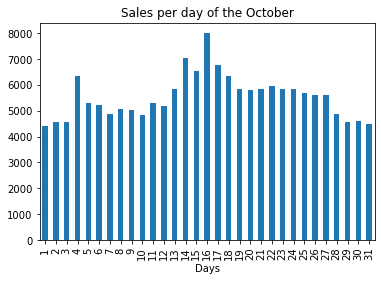

In [26]:
# bar graph showing the sales per day of the October
plt.title('Sales per day of the October')
sam_df['day'].value_counts(sort=False).plot.bar()
plt.xlabel('Days')
plt.show()

__No Specific pattern (Sales are high around the days of Halloween)__

In [27]:
# joining the countsDf which has the number of quantity and keeping only the transactions which has quantity greater than one
joinedDf = pd.merge(left=countsDf, right=sam_df,on='user_session')
joinedDf.rename(columns={'productType_x':'quantity'},inplace=True)
joinedDf.rename(columns={'productType_y':'productType'},inplace=True)

In [28]:
joinedDf = joinedDf[joinedDf['quantity']>1]
joinedDf.drop(columns='quantity',inplace=True)

In [29]:
warnings.filterwarnings('ignore')
RuleMiner(joinedDf, min_support_popular_set=0.00005, min_support_rules=0.01, metric='confidence')[:40]

Processing 120 combinations | Sampling itemset size 4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
72,"(microwave, oven)",(hob),0.000060,0.000419,0.00006,1.000000,2384.428571,0.000060,inf
66,"(oven, dishwasher)",(hob),0.000060,0.000419,0.00006,1.000000,2384.428571,0.000060,inf
80,(hob),"(refrigerators, oven)",0.000419,0.000060,0.00006,0.142857,2384.428571,0.000060,1.166597
77,"(refrigerators, oven)",(hob),0.000060,0.000419,0.00006,1.000000,2384.428571,0.000060,inf
73,(hob),"(microwave, oven)",0.000419,0.000060,0.00006,0.142857,2384.428571,0.000060,1.166597
67,(hob),"(oven, dishwasher)",0.000419,0.000060,0.00006,0.142857,2384.428571,0.000060,1.166597
70,"(hob, microwave)",(oven),0.000060,0.000539,0.00006,1.000000,1854.555556,0.000060,inf
81,(oven),"(refrigerators, hob)",0.000539,0.000060,0.00006,0.111111,1854.555556,0.000060,1.124933
65,"(hob, dishwasher)",(oven),0.000060,0.000539,0.00006,1.000000,1854.555556,0.000060,inf
68,(oven),"(hob, dishwasher)",0.000539,0.000060,0.00006,0.111111,1854.555556,0.000060,1.124933


__In the results above we see massive lift values but equally low support values. Because the number of transactions for a given combination of products lets say (oven, microwave)->(hob) is so low compared to the total number of transactions, even with massive lift value this result doesn't indicate a strong association between these products.__

## Notes
- The support of 0.00006 is found in most of the rules which signifies the same transactions are being shown in different combination
- Unique transactions such as (Dishwasher, Hob, Oven) (Microwave, Hob, Oven) (Refrigerator, Hob, Oven) (Hood, Hob, Oven) are only occuring once but almost all the time (Hob, Oven) occurs. Therefore, the (Hob, Oven) has more support value comparatively.
- The below commented code are the transactions about which second point refers to. 

__SamDf Commented code for verfying the transactions.__

In [30]:
# Specific code we want to hide:
# ==============================
# @hidden
from IPython.display import HTML
password="xxxxx"
# ==============================

# Necessary script to hide the cell:
# ==============================
HTML('''<script>
  code_show=true; 
  function code_toggle() {
    if (code_show){
        $('.cm-comment:contains(@hidden)').closest('div.input').hide();
    } else {
        $('.cm-comment:contains(@hidden)').closest('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
To show the code hidden: click <a href="javascript:code_toggle()">here</a>.''')
# ===============================================================================================

#df_main.query('user_session.str.contains("0282fc25-6010-44b")', engine='python')
#sam_df[sam_df['productType']=='hob']
#sam_df[sam_df['user_session']=='9c9801ab-047b-4a67-a189-720295bf31fb']
#sam_df[sam_df['user_session']=='a0547bcc-62ca-4e5d-9647-a4d4f20c11cc']
#sam_df[sam_df['user_session']=='6727c643-3ad1-4d49-9bc8-e38bdd2cf34c']
#sam_df[sam_df['user_session']=='a0547bcc-62ca-4e5d-9647-a4d4f20c11cc']
#sam_df[sam_df['user_session']=='9c9801ab-047b-4a67-a189-720295bf31fb']
#sam_df[sam_df['user_session']=='6727c643-3ad1-4d49-9bc8-e38bdd2cf34c']
#joinedDf[joinedDf['productType']=='dishwasher']
#sam_df[sam_df['user_session']=='9c9801ab-047b-4a67-a189-720295bf31fb']

##  Removing the singleton transactions from mainDf which has all the brands.

In [31]:
countsDfMain = df_main.groupby(by='user_session')[['productType', 'day']].agg({'productType':'count'})

In [32]:
joinedDfMain = pd.merge(left=countsDfMain, right=df_main,on='user_session')
joinedDfMain.rename(columns={'productType_x':'quantity'},inplace=True)
joinedDfMain.rename(columns={'productType_y':'productType'},inplace=True)

In [33]:
joinedDfMain = joinedDfMain[joinedDfMain['quantity']>1]
joinedDfMainD=joinedDfMain.drop(columns='quantity')
joinedDfMainD['user_session'].nunique()

58435

In [34]:
warnings.filterwarnings('ignore')
RuleMiner(joinedDfMainD, min_support_popular_set=0.00005, min_support_rules=0.01, metric='confidence')[:40]

Processing 25 combinations | Sampling itemset size 5 43


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
954,"(motherboard, power_supply)","(cooler, hdd)",0.000154,0.000086,0.000051,0.333333,3895.666667,0.000051,1.499872
955,"(cooler, hdd)","(motherboard, power_supply)",0.000086,0.000154,0.000051,0.600000,3895.666667,0.000051,2.499615
956,"(power_supply, cooler)","(motherboard, hdd)",0.000103,0.000188,0.000051,0.500000,2656.136364,0.000051,1.999624
953,"(motherboard, hdd)","(power_supply, cooler)",0.000188,0.000103,0.000051,0.272727,2656.136364,0.000051,1.374859
655,(power_supply),"(cooler, hdd)",0.000496,0.000086,0.000068,0.137931,1612.000000,0.000068,1.159901
654,"(cooler, hdd)",(power_supply),0.000086,0.000496,0.000068,0.800000,1612.000000,0.000068,4.997519
64,(pillow),(blanket),0.000171,0.000188,0.000051,0.300000,1593.681818,0.000051,1.428303
65,(blanket),(pillow),0.000188,0.000171,0.000051,0.272727,1593.681818,0.000051,1.374765
961,(power_supply),"(motherboard, cooler, hdd)",0.000496,0.000068,0.000051,0.103448,1511.250000,0.000051,1.115308
948,"(motherboard, cooler, hdd)",(power_supply),0.000068,0.000496,0.000051,0.750000,1511.250000,0.000051,3.998015


__We see the same scenario repeated here as we saw with Samsung data__

### Some code snippets which we used to confirm the number of transactions and verfying the values of support and confidence. 

In [35]:
# Specific code we want to hide:
# ==============================
# @hidden
from IPython.display import HTML
password="xxxxx"
# ==============================

# Necessary script to hide the cell:
# ==============================
HTML('''<script>
  code_show=true; 
  function code_toggle() {
    if (code_show){
        $('.cm-comment:contains(@hidden)').closest('div.input').hide();
    } else {
        $('.cm-comment:contains(@hidden)').closest('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
To show the code hidden: click <a href="javascript:code_toggle()">here</a>.''')
# ===========================================================================================================================

#joinedDfMain[joinedDfMain['productType']=='motherboard'].head(40)
#joinedDfMain[joinedDfMain['user_session']=='1269f2d5-2c9c-462e-b120-e21e3acb5b84']
#joinedDfMain[joinedDfMain['user_session']=='570f002a-cf15-4864-b409-d32da4c319e2']

#joinedDfMain[joinedDfMain['productType']=='monitor'& joinedDfMain['productType']=='cooler'].head(40)
#joinedDfMain[joinedDfMain['productType'].isin(['cooler','power_supply','hdd','motherboard']) & joinedDfMain['quantity']>1]

#joinedDfMain[joinedDfMain['user_session']=='06610b27-1dee-4744-9207-02bbe9078aca']

#joinedDfMain[joinedDfMain['user_session']=='f5cf447c-b248-40b1-8b87-03525635e88d']


#joinedDfMain[joinedDfMain[joinedDfMain['quantity']==4].productType.isin(['cooler','power_supply','hdd','motherboard'])]

#tempDf =joinedDfMain[joinedDfMain['productType'].isin(['cooler','power_supply','hdd','motherboard'])]
#tempDf[tempDf['quantity']==4]['user_session'].value_counts()
# 5 total transactions where 

# tempDf =joinedDfMain[joinedDfMain['productType'].isin(['cooler','power_supply','hdd'])]
# tempDf[tempDf['quantity']==3]['user_session'].value_counts()
# # 5 total transactions where 

# tempDf =joinedDfMain[joinedDfMain['productType'].isin(['pillow','blanket'])]
# tempDf[tempDf['quantity']==2]['user_session'].value_counts()
# # 5 total transactions where

# tempDf =joinedDfMain[joinedDfMain['productType'].isin(['refrigerators','oven','dishwasher','washer'])]
# cc = tempDf[tempDf['quantity']==4]['user_session'].value_counts()
# cc[cc==4].head(40)
# # 5 total transactions where 

# tempDf = joinedDfMain[joinedDfMain['productType'].isin(['cooler','power_supply','hdd','motherboard'])].sort_values(by=['quantity','user_session'])
# tempDf[tempDf['quantity']>=4].head(40)

# tempDf[tempDf['quantity']>=4].tail(30)

# Conclusion

__We concluded that the Apriori algorithm is not applicable for all kinds of datasets. It is suitable where there is a high chance of multiple products being purchased together, for example, in grocery stores or sports equipment stores or departmental stores, etcetera. Since electronics are very high-priced items there are very few transactions where multiple products are frequently purchased together. Therefore, in such cases, Apriori is not useful for finding significant association rules.__

__Moreover, even where Apriori is applicable, the most important metric to consider is support because a high support value indicates a high number of transactions for a given combination of products. Then, if the lift value is greater than 1, we can conclude that the association rule is significant, and we can explore that further for greater revenue generation.__


## Additional Observations

In [36]:
# "productType" column below represents the count of productType
#__Below DataFrame represents the revenue obtained by specific product with the number of items sold.__
sam_df.groupby(by='productType')[['price', 'productType']].agg({'price':'sum', 'productType':'count'})

,price,productType
productType,,
acoustic,6245.29,19
air_conditioner,21047.53,47
cartrige,136.42,4
clocks,692828.67,2780
dishwasher,6331.89,15
hdd,11403.03,78
headphone,196064.82,2223
hob,13462.77,43
hood,8368.43,44


- From the rules obtained in the Samsung products, it is seen that the smartphones are sold the most and ~90% of the transactions are singleton. This suggests that smartphones are successfully getting sold. Therefore the products which are not sold the most, should be given significant discount/offers on smartphones. 
- Considering commodities such as \[memory, dishwasher, oven\] should be given significantly offers (heavy discounts) on smartphones.
- Through this method, Samsung can enter into the market of new commodities and experiment.
- It is preferrable to provide offers on smartphones when the commodities bought have the price greater than smartphone. 

# Future Improvision

In [37]:
df_main.productType.nunique()

118

In [38]:
len(df_main.brand.unique())

1052

__Since there are about 100 products across 1052 brands, we can build on the current results and create a ranking system to identify which "brands" are more frequently purchased together. From a business point of view this can lead to targetted marketing of brand specific baskets.__

## References

- https://github.com/ashishpatel26/Market-Basket-Analysis
- https://www.youtube.com/watch?v=guVvtZ7ZClw&t=478s
- https://stackoverflow.com/questions/66110418/hiding-cell-in-jupyter